##### Parallel LSTM Training for Sequence Prediction from Sequential Data

Vietnam National University - University of Science - Falculty of Information Technology

CSC14116 - Applied Parallel Programming


**Table of Contents:**

* Introduction
* Background
  - About RNN and LSTM
  - LSTM Architecture
* Initial Setups
  - Initialize hyper-parameters
  - Download dataset
  - Import libraries
  - Define functions
    + General Functions
    + One-hot Encoding Functions
    + Activation Functions
    + Neural Network Functions
    + Inference Functions
* Dataset
  - Information
  - Task to solve
  - Preprocessing
* Implementation
  - Parallel Strategy
  - Implementation Versions
    + Sequential Version
    + Numpy Version
    + Parallel Version 1
    + Parallel Version 2
* Result
  - Versions Comparison
  - Final Demo
* Conclusion



# Introduction

In this project, we will analyze and parallel the LSTM model (a RNN - Recurrent Neural Network) in order to improve its training speed and efficiency. By utilizing parallel processing and GPU computing, the model will be able to handle larger datasets and have shorter training duration. The specific task that we want to apply using the LSTM model in this project is time-series prediction - sequence prediction from sequential data. We will implement a raw LSTM model using only Numpy library, analyze, parallelize using Numba library, and measure the efficiency of the parallel version over the sequential version.

Keywords: `Parallel Processing`, `GPU Computing`, `NVIDIA CUDA`, `Recurrent Neural Network (RNN)`, `Long Short-Term Memory (LSTM)`

# Background

## About RNN and LSTM

A recurrent neural network (RNN) trains on input containing sequences of data, as it learns about time dependent relations between different parts of the input. For example, if we send as input a sequence of words, i.e. a sentence, an RNN can learn about the relations between different words, and hence learn rules of grammar such as relationships between verbs and adverbs, etc.

LSTM stands for Long Short-Term Memory. It is a type of recurrent neural network (RNN) that is designed to handle the problem of vanishing gradients in traditional RNNs. LSTM networks have the ability to selectively remember or forget information over long periods of time, making them particularly effective for tasks that involve sequential data, such as speech recognition, language translation, and time series prediction.

## LSTM Architecture

A basic LSTM neural network contains an input layer, hidden layer and output layer, containing $n_x$, $n_h$ and $n_y$ nodes. A data point $x_i$ contains $n_x$ features at every time-step $t$, sent to the LSTM. The connections between the input and hidden nodes are parametrized by a weight matrix $W_{xh}$ of size $n_x × n_h$. The weights in the hidden layer represent recurrent connections, where connections from hidden layer at time-step $t$ to those at time-step $t + 1$ (i.e. $h_t$ to $h_{t+1}$) are parametrized by a weight matrix $W_{hh}$ of size $n_h × n_h$. Finally, weights from the hidden layer to the output layer at every time-step are parametrized by a weight matrix $W_{hy}$ , of size $n_h × n_y$.

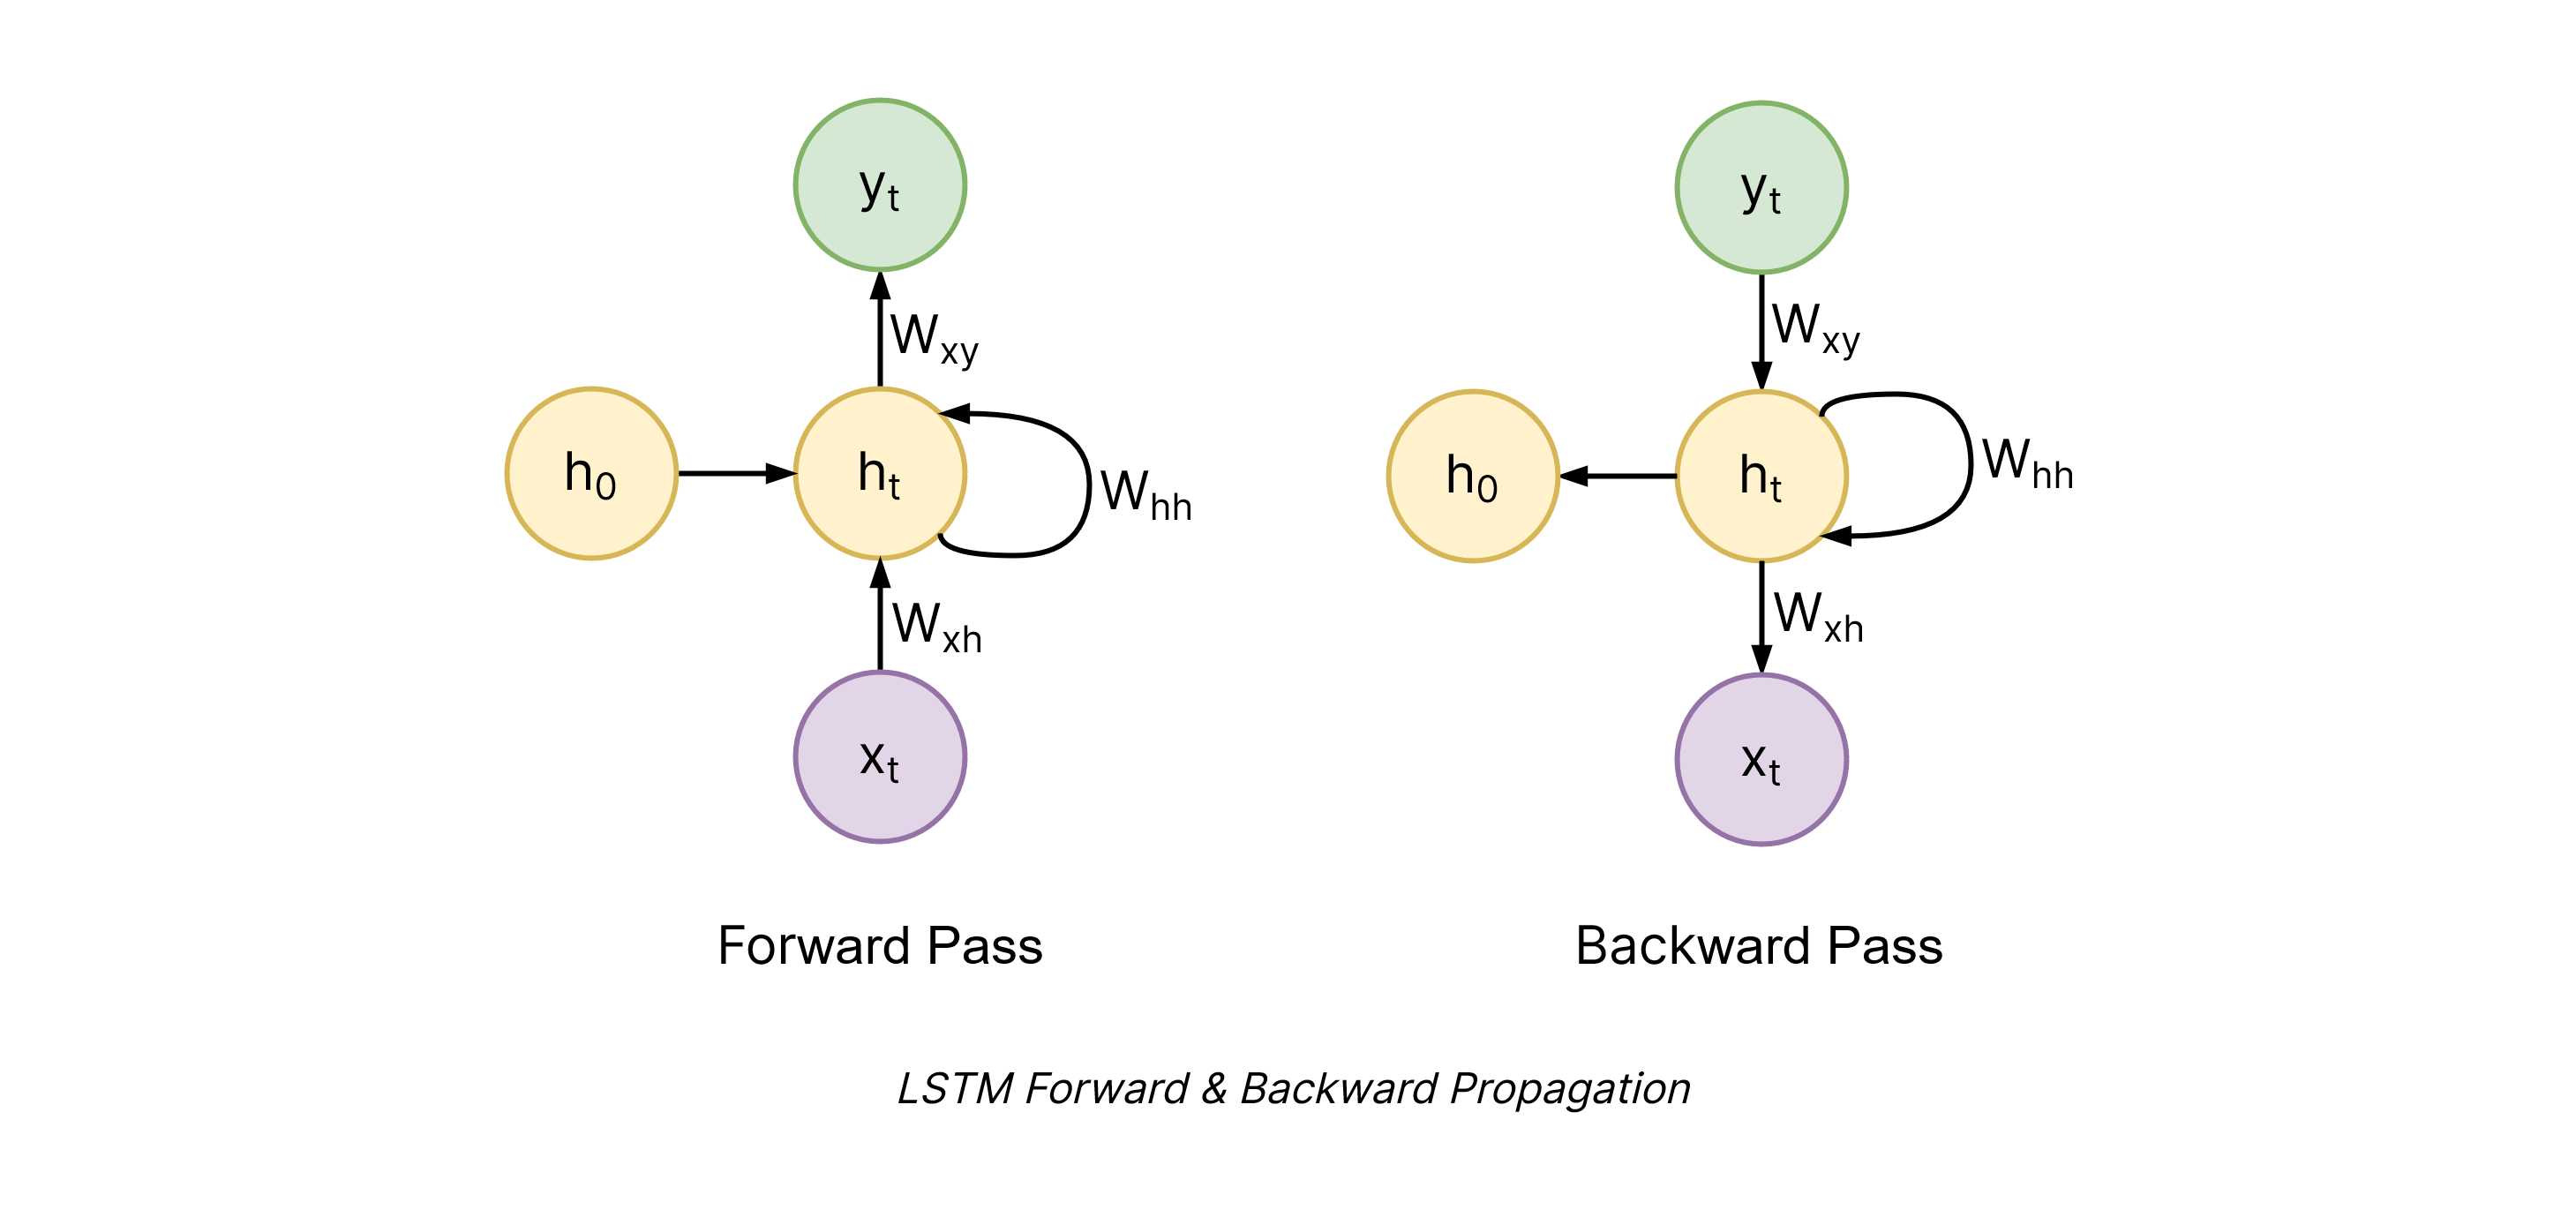

There are some important steps involved in training an LSTM:

1. **Forward Pass (Forward Propagation)**

   In this step, in general, given an input data point $x = x_1, x_2, ... , x_T$ of $T$ time-steps, the LSTM calculates the output $y = y_1, y_2, ... , y_T$ of $T$ time-steps (this can vary for different applications). All the updates are propagated from $h_1$ to $h_T$.

2. **Backward Pass (Backpropagation Through Time)**

   In this step, the LSTM do the calculating for optimization method, in this project, we will use gradient descent (more details in the Implementation section). For this, gradients from time-step $T$ have to be propagated all the way back to time-step 1.
 
3. **Parameters Updating**

   Now, the LSTM updates the weight matrices using the gradient descent calculated from the previous step.

# Initial Setups

## Initialize hyper-parameters

In [105]:
# Some hyper-parameters
hidden_size = 50
window_size = 12
training_start = 0.5
prediction_start = 1 - 20/2048

## Import libraries

In [106]:
# Import libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import cuda
import time

import warnings
from numba import NumbaPerformanceWarning
from numpy.exceptions import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
warnings.filterwarnings('ignore', category=VisibleDeprecationWarning)
np.random.seed(42)
plt.style.use('ggplot')

## Define functions

### General Functions

In [107]:
# Function: Load the main demo dataset
def load_dataset(directory, max_windows = 1):

    df = pd.read_csv(directory)

    df.drop('time', axis=1, inplace=True)
    df['Change'] = df['close'].shift(-1) - df['close']
    df['Upper_Bound'] = [ 0.5 * x + 15 for x in range(len(df))]
    df['Lower_Bound'] = [-0.6 * x -  7 for x in range(len(df))]
    df.dropna(inplace=True)

    def change_normalized(row):
        if row['Change'] >= 0:
            return row['Change'] / row['Upper_Bound']
        else:
            return - row['Change'] / row['Lower_Bound']
    df['Change_Normalized'] = df.apply(change_normalized, axis=1)

    k = 3
    lst = df['Change_Normalized'].tolist()
    clusters, centroids = k_means_clustering(lst, k)
    devide_lines = []
    for i in range(len(centroids) - 1):
        devide_lines.append((centroids[i] + centroids[i+1]) / 2)

    def change_encoded(row):
        for i, line in enumerate(sorted(devide_lines)):
            if row['Change_Normalized'] < line:
                return i
        return len(devide_lines)
    df['Change_Encoded'] = df.apply(change_encoded, axis=1)

    # df['Change_Encoded'] -> sequences
    raw_data = [str(e) for e in df['Change_Encoded'].to_list()]
    sequences = []
    for i in range(len(raw_data) - window_size * max_windows):
        for u in range(max_windows):
            sequences.append(raw_data[i : i + window_size * (u+1)])
    print(sequences)

    return sequences, raw_data, df, centroids, devide_lines

# Function: Generate a quick test dataset
def generate_dataset(num_sequences = 50, max_num_each_token = 5):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, max_num_each_token)
        sample = ['A'] * num_tokens + ['B'] * num_tokens + ['C'] * num_tokens + ['EOS']
        samples.append(sample)
    return samples

# Function: List of sequences -> word_to_idx, idx_to_word, num_sentences, vocab_size
def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist] # Flatten a nested list
    all_words = flatten(sequences)
    # Count number of word occurences
    word_count = {}
    for word in flatten(sequences):
        word_count[word] = 0
    for word in flatten(sequences):
        word_count[word] = word_count[word] + 1
    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)
    # Create dictionaries so that we can go from word to index and back
    word_to_idx = {}
    idx_to_word = {}
    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size

# Function: Create and split dataset into Train/Val/Test set
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # Train/Val/Test ratio
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    # Split sequences into Train/Val/Test
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]
    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets
    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    # Create datasets
    training_set = [(inputs_train[i], targets_train[i]) for i in range(len(inputs_train))]
    validation_set = [(inputs_val[i], targets_val[i]) for i in range(len(inputs_val))]
    test_set = [(inputs_test[i], targets_test[i]) for i in range(len(inputs_test))]    
    return training_set, validation_set, test_set

def create_actual_and_predicted_df(df):
    actual_and_predicted = pd.DataFrame({
        'Actual': df['close'][int(prediction_start * len(df))-1 : -1].shift(-1), 
        'Predicted': df['Passengers_Prediction'][int(prediction_start * len(df))-2 : -2],
    })
    # actual_and_predicted['Actual'] = actual_and_predicted['Actual'] - 30
    actual_and_predicted.dropna(inplace=True)
    return actual_and_predicted

def calculate_rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Determines if the RMSE is considered good based on the rule:
# RMSE should be less than 10% of the range or standard deviation of the target variable.
def is_rmse_good(rmse, target_variable):
    threshold = 0.1 * (np.max(target_variable) - np.min(target_variable)) # Alternatively: 0.1 * np.std(target_variable)
    print("Limit:", threshold)
    if rmse < threshold:
        return True
    else:
        return False

### One-hot Encoding Functions

In [108]:
# Function: One-hot encoding a Token
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

# Function: One-hot encoding a Sequence (list of tokens)
def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

# Function: One-hot encoding Train/Val/Test sets
def one_hot_encode_set(training_set, validation_set, test_set, vocab_size):
    training_set_one_hot = []
    validation_set_one_hot = []
    test_set_one_hot = []
    for idx, (inputs, targets) in enumerate(training_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        training_set_one_hot.append((inputs_one_hot, targets_one_hot))
    for idx, (inputs, targets) in enumerate(validation_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        validation_set_one_hot.append((inputs_one_hot, targets_one_hot))
    for idx, (inputs, targets) in enumerate(test_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        test_set_one_hot.append((inputs_one_hot, targets_one_hot))
    training_set_one_hot = tuple(training_set_one_hot)
    validation_set_one_hot = tuple(validation_set_one_hot)
    test_set_one_hot = tuple(test_set_one_hot)
    return training_set_one_hot, validation_set_one_hot, test_set_one_hot

# Function: Help initializing parameters
def randn(x, y):
  return np.array([[0.5 if (u+i)%2==0 else -0.5 for u in range(y)] for i in range(x)])

# Funciton: Simple K-Means to find centroids of data points
def k_means_clustering(lst, k):
    centroids = sorted(lst)[:k]
    clusters = [[] for _ in range(k)]
    while True:
        new_clusters = [[] for _ in range(k)]
        for num in lst:
            distances = [abs(num - centroid) for centroid in centroids]
            closest_centroid_index = distances.index(min(distances))
            new_clusters[closest_centroid_index].append(num)
        if new_clusters == clusters:
            break
        clusters = new_clusters
        centroids = [sum(cluster) / len(cluster) for cluster in clusters]
    return clusters, centroids

# Function: Print some basic information about the dataset
def print_data_basic_info(sequences, num_sequences, vocab_size, word_to_idx, idx_to_word, training_set, validation_set, test_set):
    print(f"Example sequence: {sequences[0]}\n")
    print(f"Num of sequences (Dataset size):\t{num_sequences} sequences")
    print(f"Num of tokens (Vocab size):\t\t{vocab_size} tokens")
    print("\nword_to_idx:")
    for item in word_to_idx:
      print(f"'{item}' -> {word_to_idx[item]}")
    print("\nidx_to_word:")
    for item in idx_to_word:
      print(f"{item} -> '{idx_to_word[item]}'")
    print(f"\nDataset splitting:")
    print(f'Train:\t\t{len(training_set)} samples')
    print(f'Validation:\t{len(validation_set)} samples')
    print(f'Test:\t\t{len(test_set)} samples')

### Activation Functions

In [109]:
# Activation Function: Sigmoid
def sigmoid(x, derivative=False):
    if derivative:
        return (1 / (1 + np.exp(- x - 1e-12))) * (1 - (1 / (1 + np.exp(- x - 1e-12))))
    else:
        return 1 / (1 + np.exp(- x - 1e-12))

# Activation Function: Tanh
def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

# Activation Function: Softmax
def softmax(x, derivative=False):
    if derivative:
        pass
    else:
        return np.exp(x + 1e-12) / np.sum(np.exp(x + 1e-12))

### Neural Network Functions

In [110]:
# Function: Initialize the neural network
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

# Function: Initialize the LSTM network
def init_lstm(hidden_size, vocab_size):
    U = np.zeros((hidden_size, vocab_size))
    V = np.zeros((hidden_size, hidden_size))
    W = np.zeros((vocab_size, hidden_size))
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    return U, V, W, b_hidden, b_out

# Function: Update parameters of the network
def update_parameters(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad * 10.0
    return params

# Function: LSTM Forward Pass
def forward_pass(inputs, h, U, V, W, B, b_out, outputs, h_s):
    for idf in range(len(inputs)):
        h = tanh(np.dot(U, inputs[idf]) + np.dot(V, h) + B)
        h_s[idf] = h
        outputs[idf] = softmax(np.dot(W, h) + b_out)
    return outputs, h_s

# Function: LSTM Backward Pass
def backward_pass(inputs, outputs, h_s, targets, V, W, d_U, d_V, d_W, d_B, d_h_next):
    loss = 0
    for idb_r in range(hidden_size):
        d_h_next[idb_r][0] = 0
    for idb in reversed(range(len(inputs))):
        loss = loss - np.mean(np.log(outputs[idb]+1e-12) * targets[idb])
        outputs[idb][np.argmax(targets[idb])] = outputs[idb][np.argmax(targets[idb])] - 1
        d_f = tanh(h_s[idb], derivative=True) * (np.dot(W.T, outputs[idb]) + d_h_next)
        d_h_next = np.dot(V.T, d_f)
        d_U = d_U + np.dot(d_f, inputs[idb].T)
        if idb != 0:
            d_V = d_V + np.dot(d_f, h_s[idb-1].T)
        elif idb == 0:
            d_V = d_V + np.dot(d_f, h_s[len(inputs)-1].T)
        d_W = d_W + np.dot(outputs[idb], h_s[idb].T)
        d_B = d_B + d_f
    clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U, 2)) + np.sum(np.power(d_V, 2)) + np.sum(np.power(d_W, 2)) + np.sum(np.power(d_B, 2))) + 1e-6)
    if clip_coef < 1:
        d_U = d_U * clip_coef
        d_V = d_V * clip_coef
        d_W = d_W * clip_coef
        d_B = d_B * clip_coef
    return loss, d_U, d_V, d_W, d_B

# # ----- Testing Area -----
# params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)
# test_input_sequence, test_target_sequence = training_set[0]
# test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
# test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)
# hidden_state = np.zeros((hidden_size, 1))
# U, V, W, B, b_out = params
# d_U_TEMP = np.zeros((hidden_size, vocab_size))
# d_V_TEMP = np.zeros((hidden_size, hidden_size))
# d_W_TEMP = np.zeros((vocab_size, hidden_size))
# d_B_TEMP = np.zeros((hidden_size, 1))
# d_h_next_TEMP = np.zeros((hidden_size, 1))
# outputs = np.zeros((len(test_input), vocab_size, 1))
# h_s = np.zeros((len(test_input), hidden_size, 1))
# outputs, hidden_states = forward_pass(test_input, hidden_state, U, V, W, B, b_out, outputs, h_s)
# loss, _, _, _, _ = backward_pass(test_input, outputs, hidden_states, test_target, V, W, d_U_TEMP, d_V_TEMP, d_W_TEMP, d_B_TEMP, d_h_next_TEMP)
# print(outputs[0][0][0])
# print(loss)
# # 0.4737177338703963
# # 0.8153365026285508

### Inference Functions

In [111]:
# Function: Inference the next token based on an input sequence
def inference_next_token(params, sentence, prob = 1):
    sentence_cut = sentence[:]
    sentence_one_hot = one_hot_encode_sequence(sentence_cut, vocab_size)
    hidden_state = np.zeros((hidden_size, 1))
    U, V, W, b_hidden, b_out = params
    outputs = np.zeros((len(sentence_one_hot), vocab_size, 1))
    h_s = np.zeros((len(sentence_one_hot), hidden_size, 1))
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, U, V, W, b_hidden, b_out, outputs, h_s)
    output_sentence = sentence
    word = idx_to_word[np.argsort(np.max(outputs[-1], axis=1))[-prob]]
    output_sentence.append(word)
    return output_sentence

# Function: Inference the next sequence by calling inference_next_token multiple times
def inference_next_sequence(params, sentence, num_tokens = 1):
    output = sentence.split(' ')
    for _ in range(num_tokens):
        output = inference_next_token(params, output)
    return output

In [112]:
# Function: Inference on the main demo dataset
def predict_US_airline_passengers(df, params, raw_data, centroids, devide_lines):
    prediction_starting_point = int(prediction_start * len(raw_data))
    input_sequence = ' '.join([e for e in raw_data[prediction_starting_point : prediction_starting_point + window_size]])
    num_tokens_to_predict = len(raw_data) - prediction_starting_point
    prediction = inference_next_sequence(params = params, sentence = input_sequence, num_tokens = num_tokens_to_predict)[window_size:]

    prediction_data = raw_data[:prediction_starting_point] + prediction
    prediction_data = [int(e) for e in prediction_data]
    df['Prediction_Encoded'] = prediction_data

    def prediction_decode(row):
        centroid = centroids[-1]
        for i, line in enumerate(sorted(devide_lines)):
            if row['Prediction_Encoded'] == i:
                centroid = centroids[i]
        if row['Change_Normalized'] >= 0:
            return centroid * row['Upper_Bound']
        else:
            return - centroid * row['Lower_Bound']
    df['Change_Prediction'] = df.apply(prediction_decode, axis=1)

    passengers_raw = df['close'].to_list()
    passengers_pred = df['Change_Prediction'].to_list()[prediction_starting_point:]
    passengers_prediction = passengers_raw[:prediction_starting_point]
    for pred in passengers_pred:
        passengers_prediction.append(passengers_prediction[-1] + pred)
    df['Passengers_Prediction'] = passengers_prediction
    return df

# Dataset

## Information

Dataset Name: US Airline Passengers

Description:
* The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960. 
* This dataset provides monthly totals of a US airline passengers from 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.

Format: `CSV` A monthly time series, in thousands.

Original Source: *Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.*

Kaggle Link: https://www.kaggle.com/datasets/chirag19/air-passengers

More details about the dataset: https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html



## Task to solve

Predict/forecast the number of passengers of a US airline.

This is a time-series prediction task and totally fit the purpose of this project, so we will build a LSTM model to solve this task.

## Preprocessing

In [113]:
# Initialize dataset
sequences, raw_data, df, centroids, devide_lines = load_dataset(directory = '/kaggle/input/dataset/AGR.csv', max_windows = 1)
sequences = sequences[int(training_start * len(raw_data)):]

# Create vocab dictionary & split into sets
word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
training_set, validation_set, test_set = create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1)

# One-hot encoding all sets
training_set_one_hot, validation_set_one_hot, test_set_one_hot = one_hot_encode_set(training_set, validation_set, test_set, vocab_size)

# # Print
# print_data_basic_info(sequences, num_sequences, vocab_size, word_to_idx, idx_to_word, training_set, validation_set, test_set)

[['0', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2'], ['2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2', '0'], ['2', '

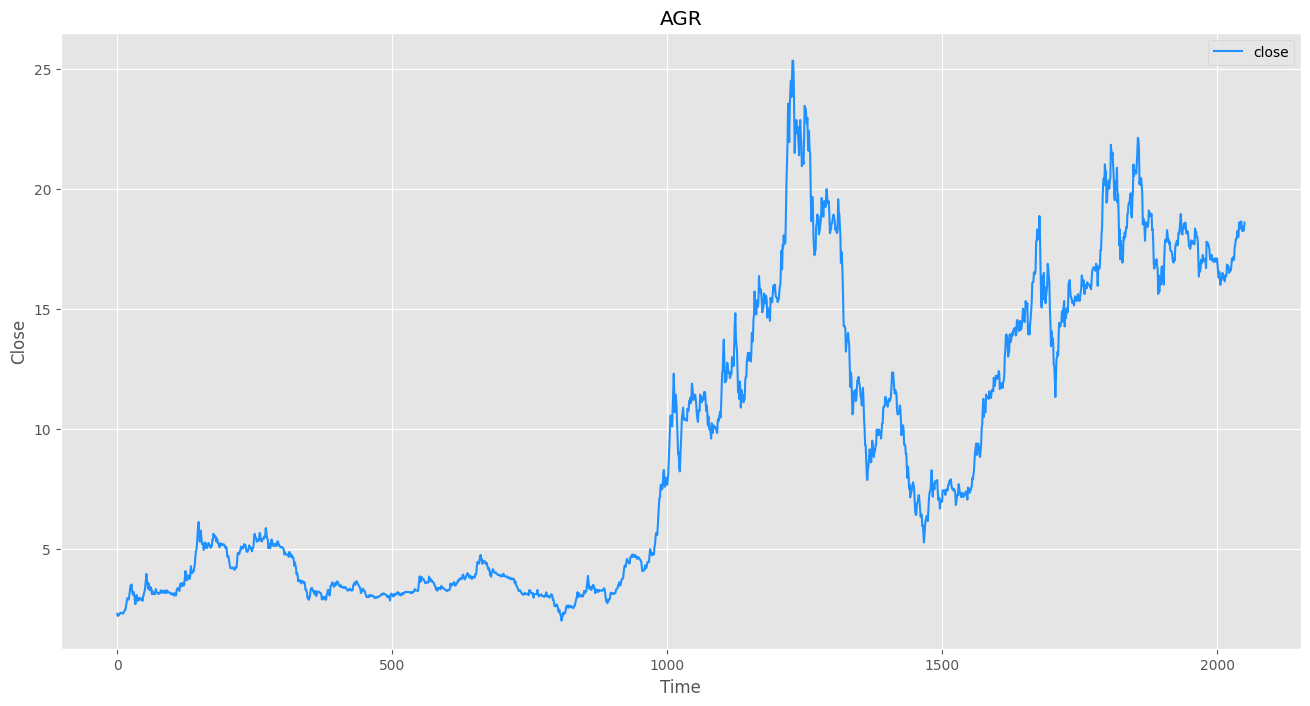

In [114]:
plt.figure(figsize=(16, 8))
plt.plot(df['close'], label = 'close', color = 'DodgerBlue')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('AGR')
plt.legend()
plt.show()

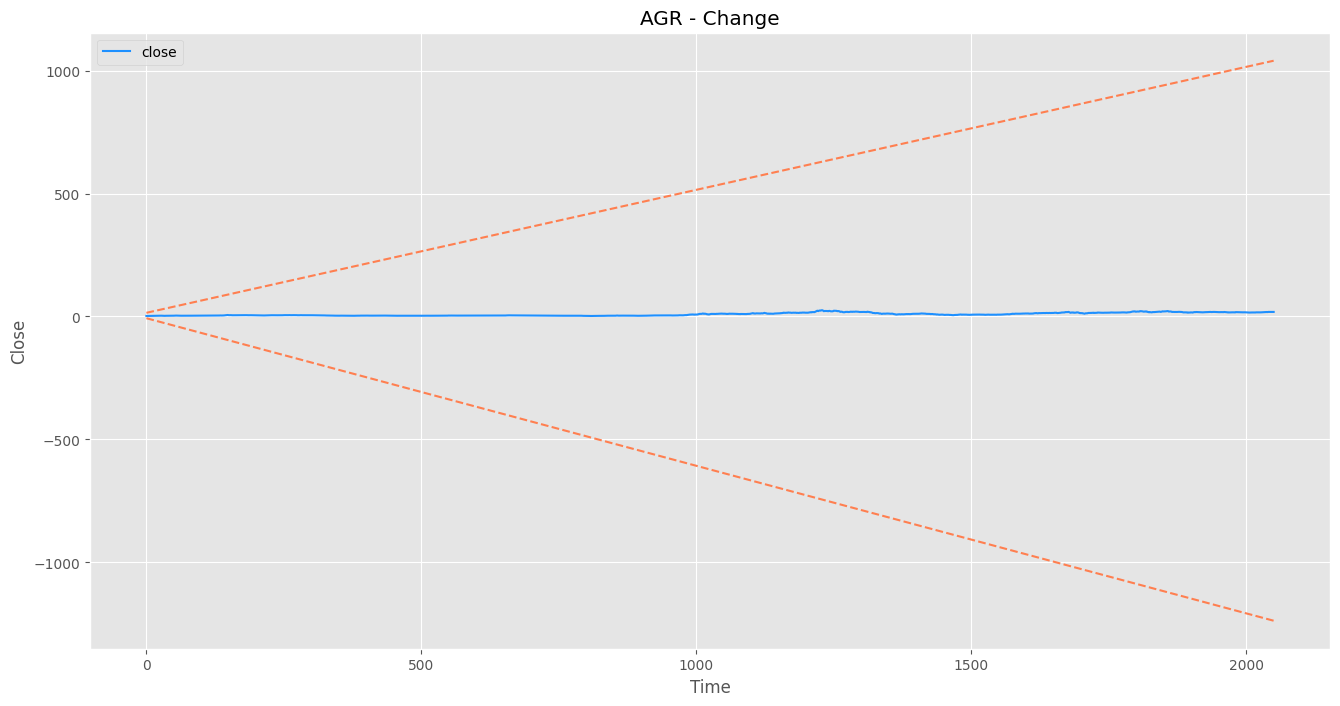

In [115]:
plt.figure(figsize=(16, 8))
plt.plot(df['close'], label = 'close', color = 'DodgerBlue')
plt.plot(df['Upper_Bound'], linestyle='--', color = 'Coral')
plt.plot(df['Lower_Bound'], linestyle='--', color = 'Coral')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('AGR - Change')
plt.legend()
plt.show()

Centroids:
[-0.012, -0.004, 0.0]
Devide Lines:
[-0.008, -0.002]


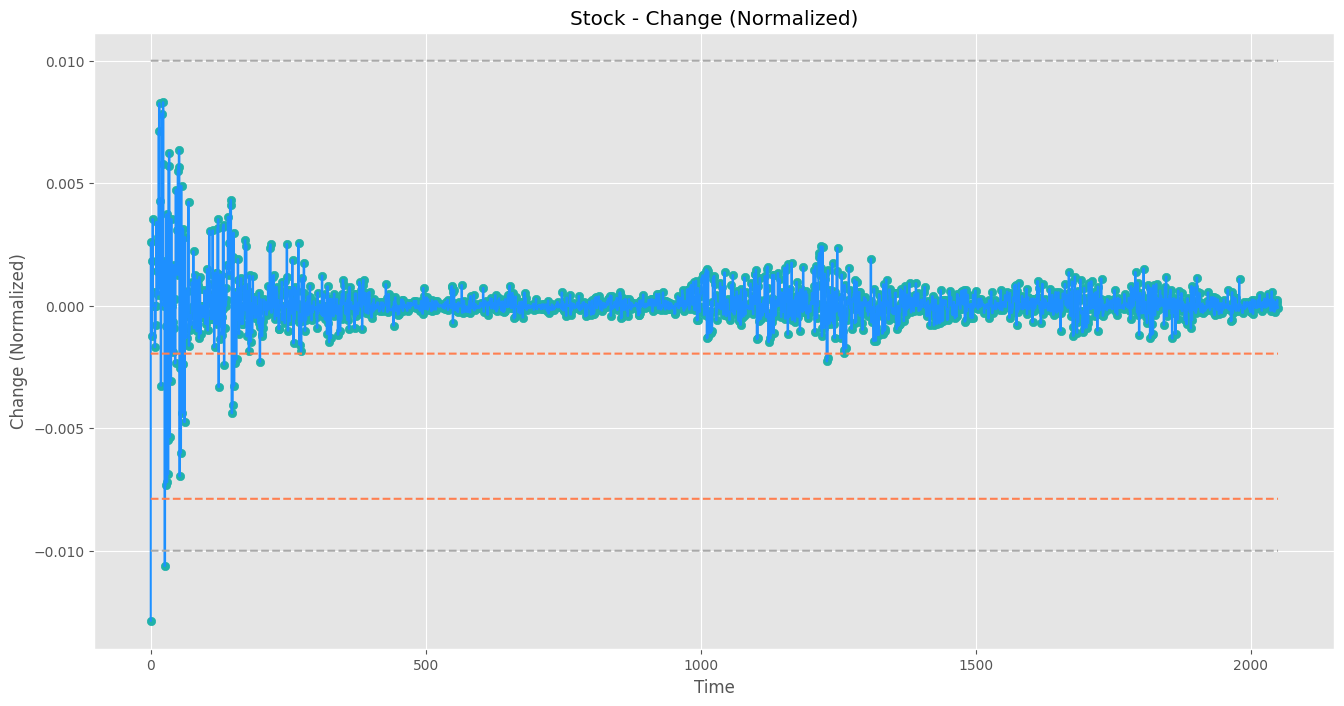

In [116]:
print('Centroids:')
print([round(c,3) for c in centroids])
print('Devide Lines:')
print([round(l,3) for l in devide_lines])

plt.figure(figsize=(16, 8))
plt.step(range(len(df)), df['Change_Normalized'], label = 'Change (Normalized)', color = 'DodgerBlue')
plt.scatter(range(len(df)), df['Change_Normalized'], color='LightSeaGreen')
plt.plot([ 0.01 for _ in range(len(df))], linestyle='--', color = 'DarkGray')
for line in devide_lines:
    plt.plot([line for _ in range(len(df))], linestyle='--', color = 'Coral')
plt.plot([-0.01 for _ in range(len(df))], linestyle='--', color = 'DarkGray')
plt.xlabel('Time')
plt.ylabel('Change (Normalized)')
plt.title('Stock - Change (Normalized)')
plt.show()

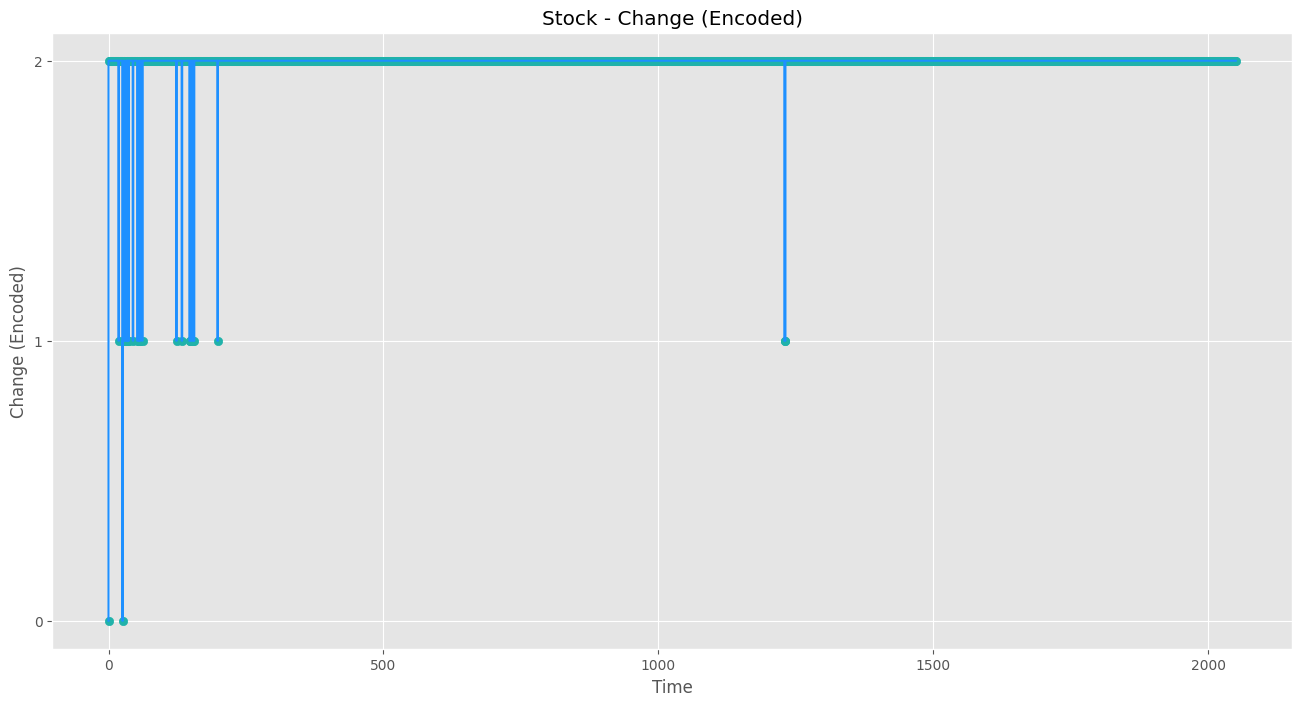

In [117]:
plt.figure(figsize=(16, 8))
plt.step(range(len(df)), df['Change_Encoded'], label = 'Change (Encoded)', color = 'DodgerBlue')
plt.scatter(range(len(df)), df['Change_Encoded'], color='LightSeaGreen')
plt.yticks(range(len(devide_lines)+1))
plt.xlabel('Time')
plt.ylabel('Change (Encoded)')
plt.title('Stock - Change (Encoded)')
plt.show()

# Implementation

## Parallel Strategy

Optimization algorithm: **Batch Gradient Descent** (**Mini-Batch Gradient Descent**)

Gradient Descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient of the function at the current point, because this is the direction of steepest descent.

Why Batch Gradient Descent instead of Stochastic Gradient Descent?

|                    | Stochastic Gradient Descent | Batch Gradient Descent     |
|--------------------|-----------------------------|----------------------------|
| Quality            | ✖️ Rough gradient          | ✔️ Good gradient           |
| Speed              | ✔️ Fast                    | ✖️ Slow                    |
| Parallel Potential |                             | ➜ Benefit from parallelism |

We will use Batch Gradient Descent as optimization method:

* The training process will loop through a number of epochs (sequential):
  * For each epoch, divide the dataset into a number of mini-batch (sequential):
    * For each mini-batch, process through a number of data samples (parallel):
      * For each data sample, process through 3 main steps: Forward Pass ➜ Backward Pass ➜ Gradient Clipping

Depends on which gradient descent method, we will update the model/network parameters as follow:
* If we use `fullbatch`, update at the end of an epoch.
* If we use `minibatch`, update at the end of a minibatch.

The diagram below presents our strategy for LSTM training parallel implementation:

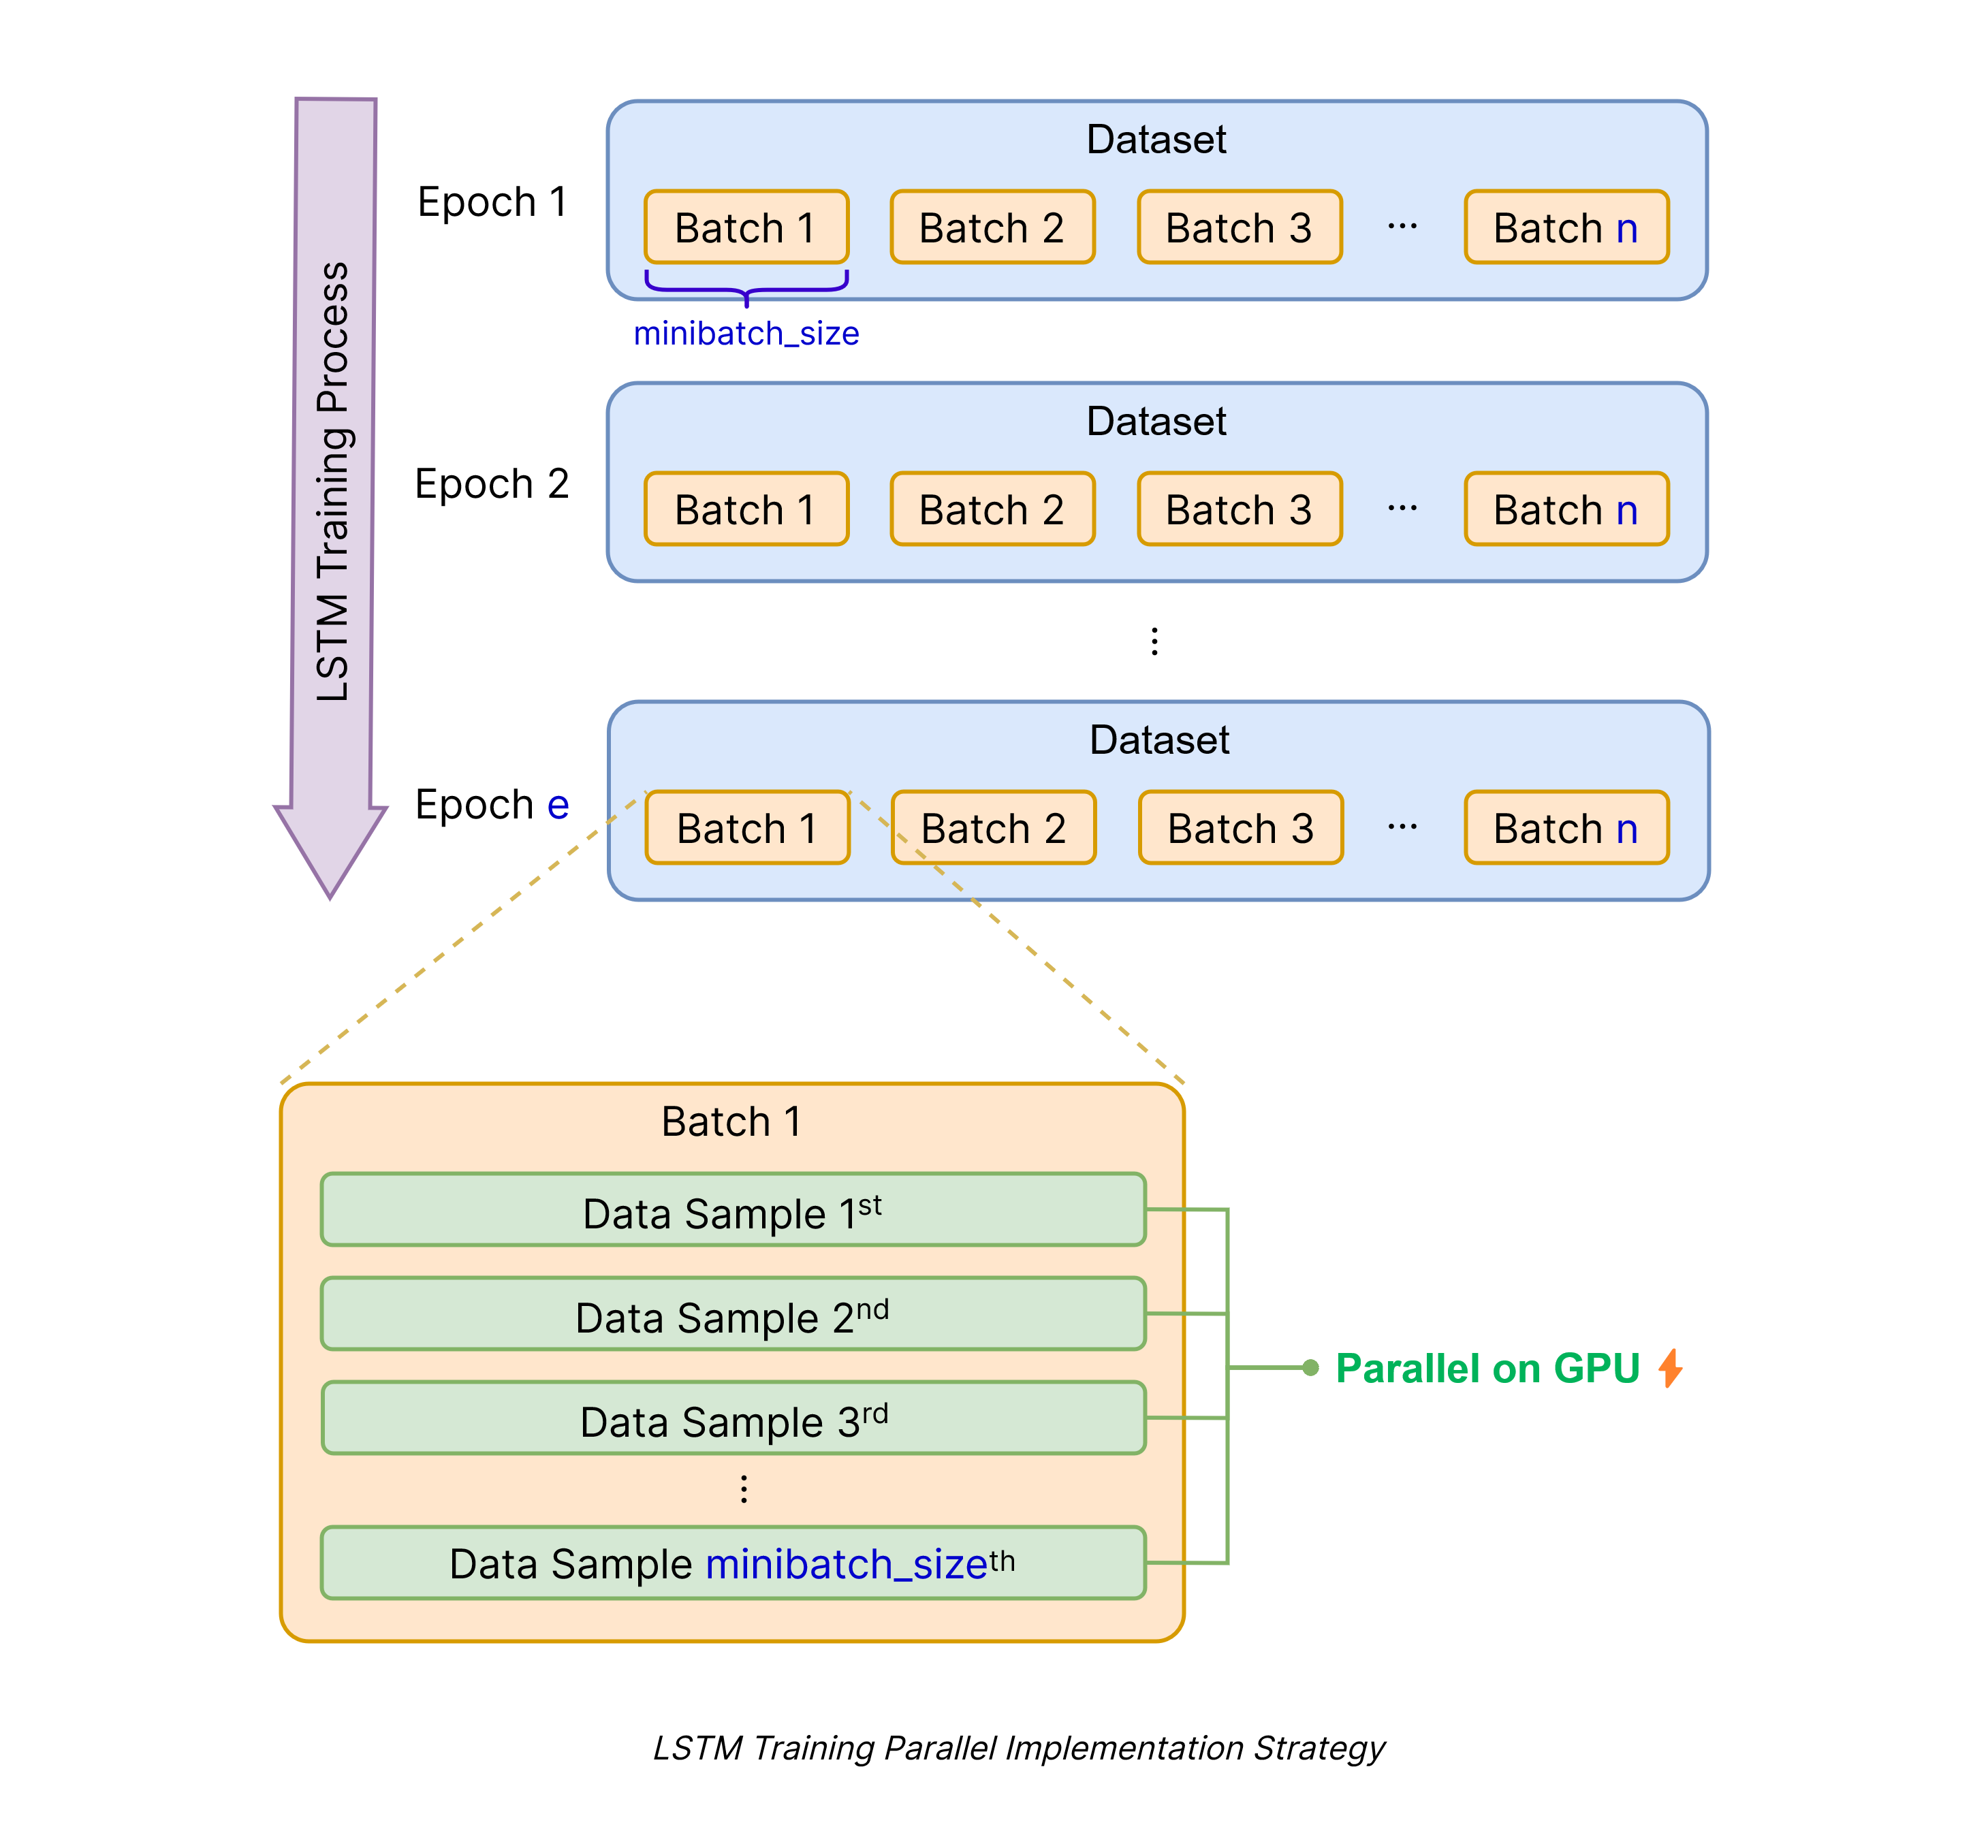

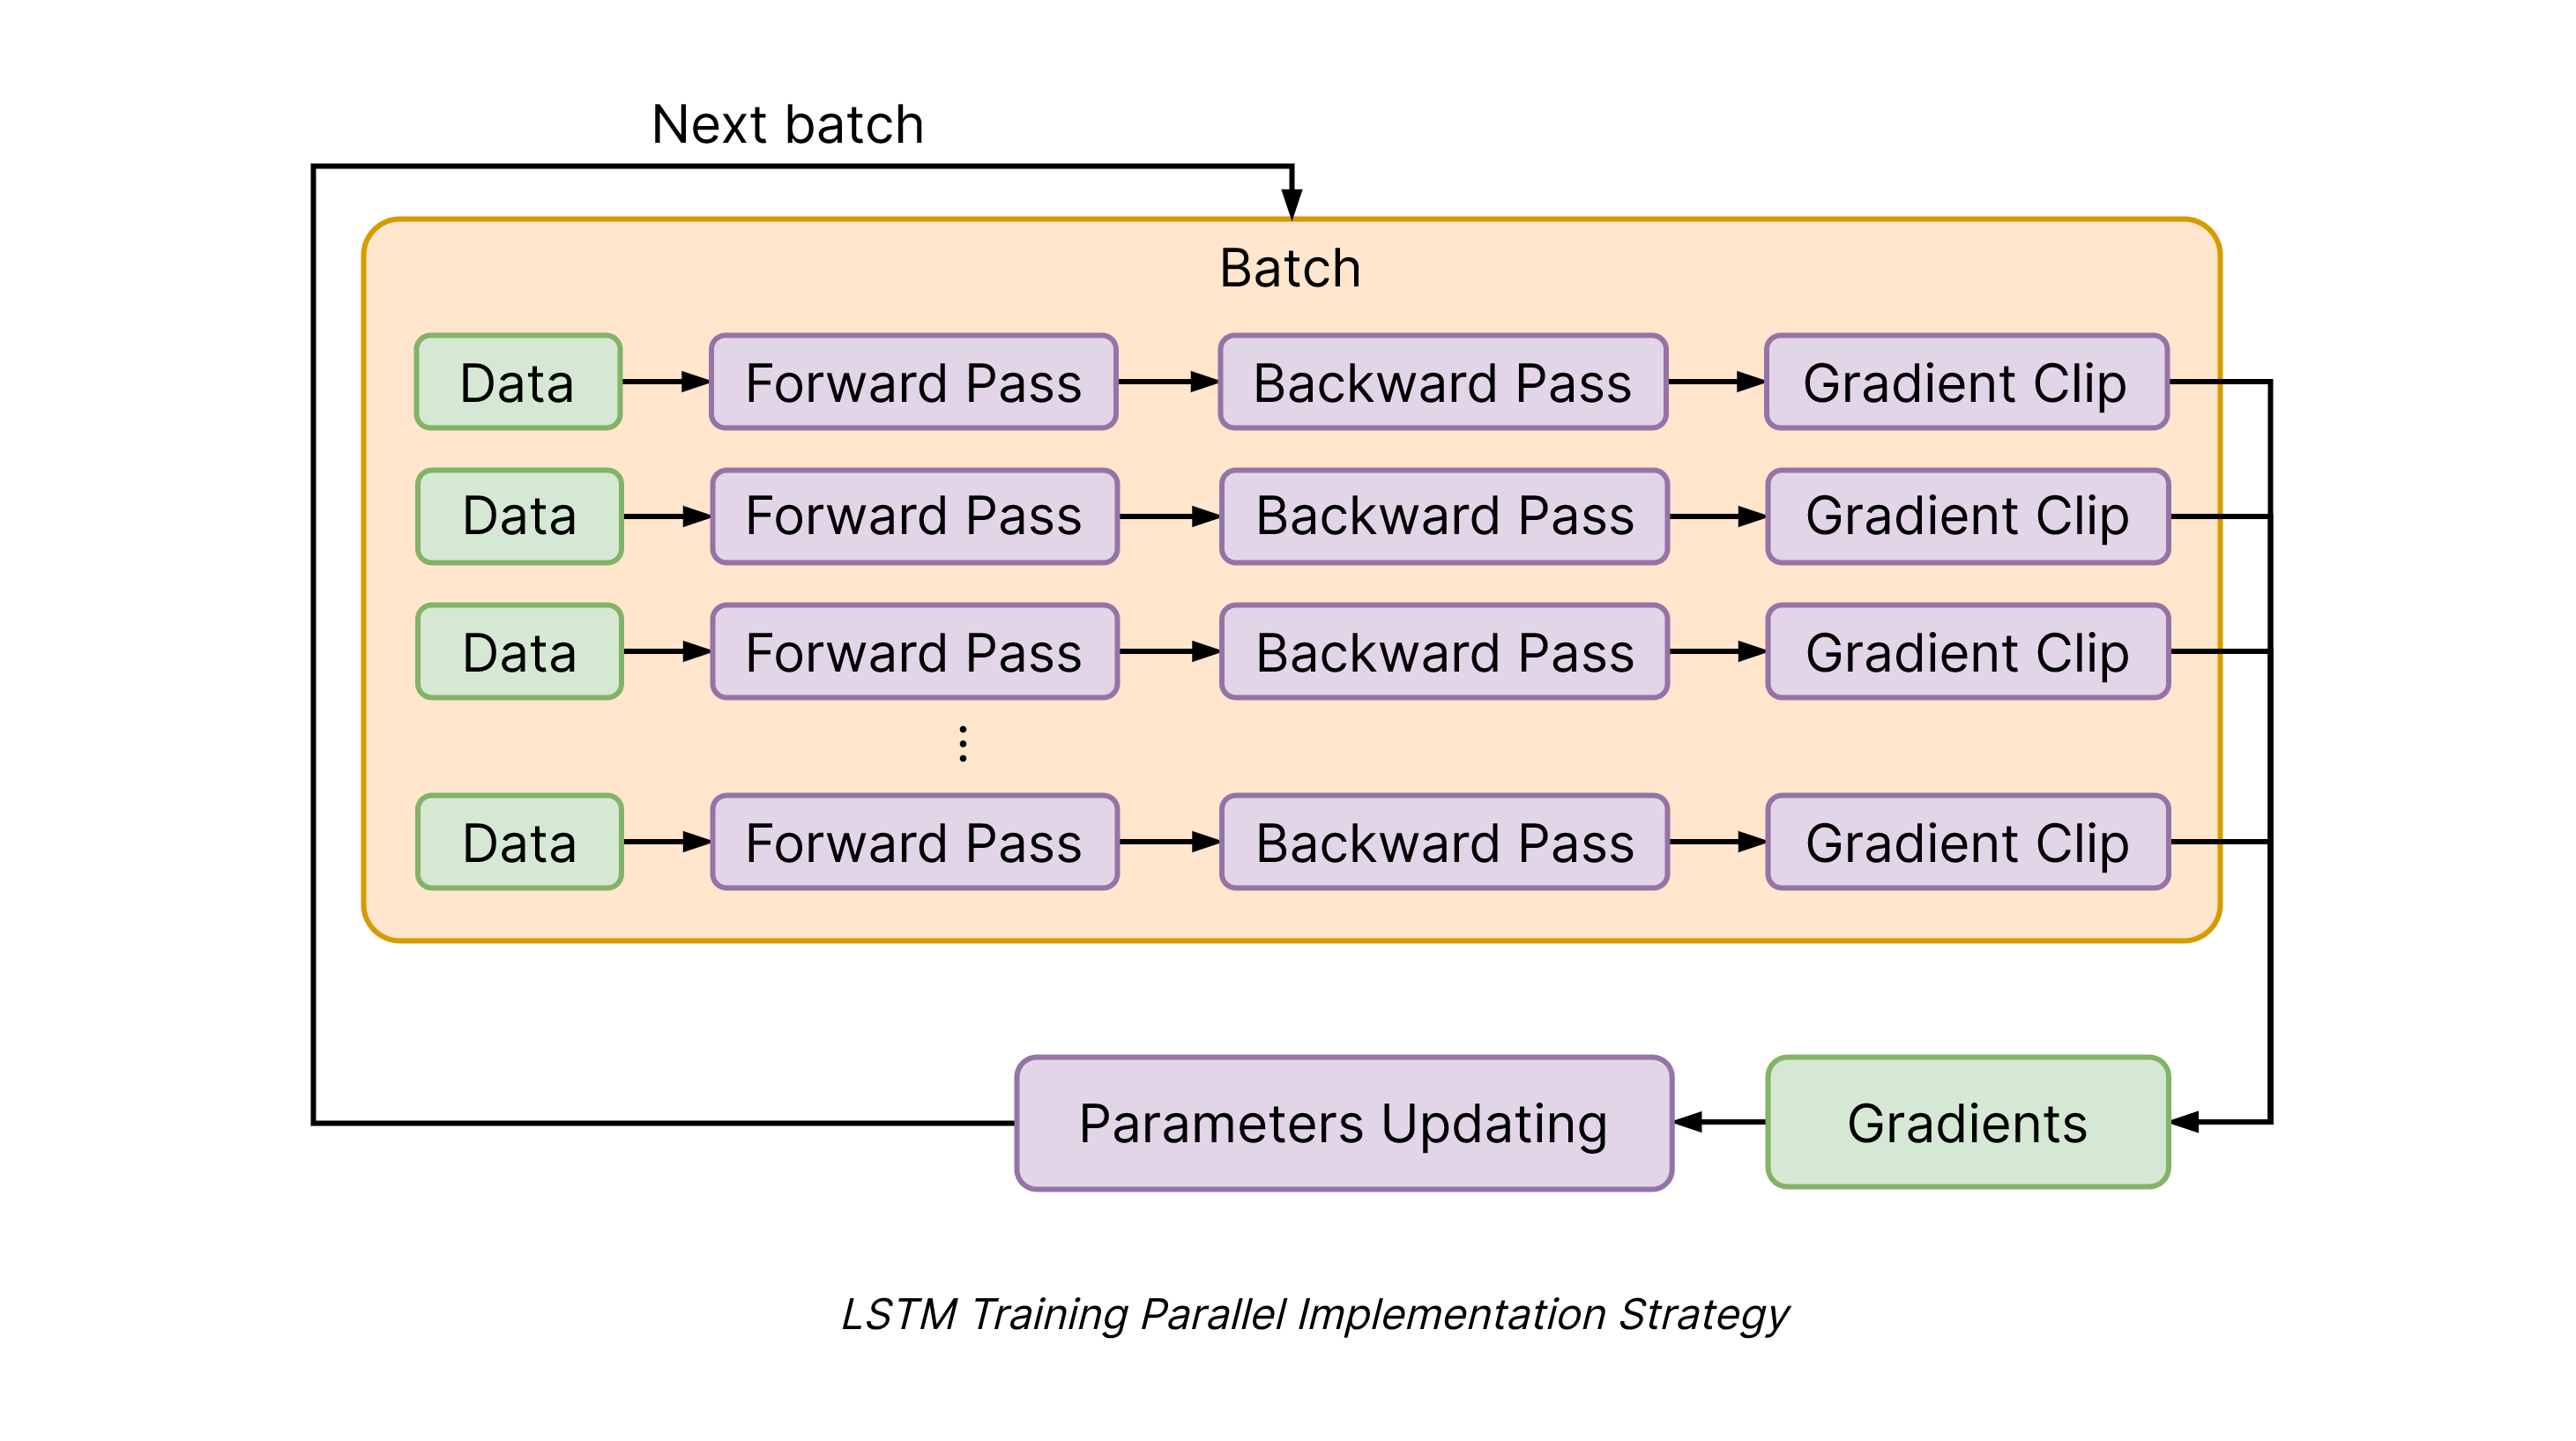

## Implementation Versions

### Sequential

This is sequential implementation of LSTM, all the processes run on CPU.

**Sequential Version:**

* Each Epoch runs on: CPU
  * Each Mini-batch runs on: **CPU** ✖️
    * Each Data sample runs on: **CPU** ✖️
      * Thread positioning: **No** ✖️
      * Optimize data transferring: **No** ✖️

How to call:

```
train_LSTM(implementation = 'sequential')
```

In [118]:
# RAW SEQUENTIAL

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_sequential(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Numpy

This is sequential implementation of LSTM, use Numpy, all the processes run on CPU.

**Numpy Version:**

* Each Epoch runs on: CPU
  * Each Mini-batch runs on: **CPU** ✖️
    * Each Data sample runs on: **CPU** ✖️
      * Thread positioning: **No** ✖️
      * Optimize data transferring: **No** ✖️

How to call:

```
train_LSTM(implementation = 'numpy')
```

In [119]:
# NUMPY

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_numpy(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            h_s[idx] = np.round(tanh(np.round(np.dot(U, inputs[idf]), round_decimal) + np.round(np.dot(V, h_s[idx]), round_decimal) + B), round_decimal) # (hidden_size, 1)

            h_s_s[idx][idf] = h_s[idx] # (hidden_size, 1)

            outputs[idx][idf] = np.round(softmax(np.round(np.dot(W, h_s[idx]), round_decimal) + b_out), round_decimal) # (vocab_size, 1)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            loss = loss - np.round(np.mean(np.round(np.log(outputs[idx][idb]+1e-12), round_decimal) * targets[idb]), round_decimal)

            outputs[idx][idb][np.argmax(targets[idb])] = outputs[idx][idb][np.argmax(targets[idb])] - 1

            d_f[idx] = np.round(tanh(h_s_s[idx][idb], derivative=True), round_decimal) * np.round((np.round(np.dot(W.T, outputs[idx][idb]), round_decimal) + h_s[idx]), round_decimal) # (hidden_size, 1)
                
            h_s[idx] = np.round(np.dot(V.T, d_f[idx]), round_decimal) # (hidden_size, 1)

            d_U[idx] = np.round(d_U[idx] + np.round(np.dot(d_f[idx], inputs[idb].T), round_decimal), round_decimal) # (hidden_size, vocab_size)

            h_s_s[idx][-1] = h_s_s[idx][len(inputs)-1] # (hidden_size, 1)

            # d_V
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            d_W[idx] = np.round(d_W[idx] + np.round(np.dot(outputs[idx][idb], h_s_s[idx][idb].T), round_decimal), round_decimal) # (vocab_size, hidden_size)

            d_B[idx] = np.round(d_B[idx] + d_f[idx], round_decimal) # (hidden_size, 1)

        # ------------------------------ Gradient Clip ------------------------------
        clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U[idx], 2)) + np.sum(np.power(d_V[idx], 2)) + np.sum(np.power(d_W[idx], 2)) + np.sum(np.power(d_B[idx], 2))) + 1e-6)

        if clip_coef < 1.0:
            d_U[idx] = np.round(d_U[idx] * clip_coef, round_decimal)
            d_V[idx] = np.round(d_V[idx] * clip_coef, round_decimal)
            d_W[idx] = np.round(d_W[idx] * clip_coef, round_decimal)
            d_B[idx] = np.round(d_B[idx] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Parallel on CPU

In [120]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.44
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [121]:
# PARALLEL ON CPU
from numba import jit, prange
from numba import config
config.THREADING_LAYER = 'omp'
@jit(parallel=True)

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_parallel_cpu(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Parallel V1

This is the first parallel implementation of LSTM to run on GPU.

This version is not actually "parallel" yet, it's just a quick convert from sequential version to test the ability to run on GPU using `numba`.

**Parallel V1:**

* Each Epoch runs on: CPU
  * Each Mini-batch runs on: **GPU** ✔️
    * Each Data sample runs on: **GPU** ✔️
      * Thread positioning: **No** ✖️
      * Optimize data transferring: **No** ✖️

How to call:

```
train_LSTM(implementation = 'parallel_v1')
```

In [122]:
# PARALLEL V1
@cuda.jit

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_parallel_v1(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s[idx] = tanh(np.dot(U, inputs[idf]) + np.dot(V, h_s[idx]) + B) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s[idx][idf] = h_s[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs[idx][idf] = softmax(np.dot(W, h_s[idx]) + b_out) # (vocab_size, 1) # ✅
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss = loss - np.mean(np.log(outputs[idx][idb]+1e-12) * targets[idb]) # ✅
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs[idx][idb][np.argmax(targets[idb])] = outputs[idx][idb][np.argmax(targets[idb])] - 1 # ✅
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f[idx] = tanh(h_s_s[idx][idb], derivative=True) * (np.dot(W.T, outputs[idx][idb]) + h_s[idx]) # (hidden_size, 1) # df can be considered to be replaced # ✅
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s[idx] = np.dot(V.T, d_f[idx]) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U[idx] = d_U[idx] + np.dot(d_f[idx], inputs[idb].T) # (hidden_size, vocab_size) # ✅
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s[idx][-1] = h_s_s[idx][len(inputs)-1] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V[idx] = d_V[idx] + np.dot(d_f[idx], h_s_s[idx][idb-1].T) # (hidden_size, hidden_size) # ✅
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W[idx] = d_W[idx] + np.dot(outputs[idx][idb], h_s_s[idx][idb].T) # (vocab_size, hidden_size) # ✅
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B[idx] = d_B[idx] + d_f[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U[idx], 2)) + np.sum(np.power(d_V[idx], 2)) + np.sum(np.power(d_W[idx], 2)) + np.sum(np.power(d_B[idx], 2))) + 1e-6) # ✅
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        # if clip_coef < 1.0: # ✅
        #     d_U[idx] = d_U[idx] * clip_coef
        #     d_V[idx] = d_V[idx] * clip_coef
        #     d_W[idx] = d_W[idx] * clip_coef
        #     d_B[idx] = d_B[idx] * clip_coef
        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Parallel V2

This is the second parallel implementation of LSTM to run on GPU.

In this version, for each mini-batch we will invoke kernel once, and each data sample in the mini-batch will run on a thread on GPU.

**Parallel V2:**

* Each Epoch runs on: CPU
  * Each Mini-batch runs on: **GPU** ✔️
    * Each Data sample runs on: **GPU** ✔️
      * Thread positioning: **Yes** ✔️
      * Optimize data transferring: No ✖️

How to call:

```
train_LSTM(implementation = 'parallel_v2')
```

In [123]:
# PARALLEL V2
@cuda.jit

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_parallel_v2(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    tx = cuda.threadIdx.x
    ty = cuda.blockIdx.x
    bw = cuda.blockDim.x
    idx = tx + ty * bw

    if idx < len(minibatch_set):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s[idx] = tanh(np.dot(U, inputs[idf]) + np.dot(V, h_s[idx]) + B) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s[idx][idf] = h_s[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs[idx][idf] = softmax(np.dot(W, h_s[idx]) + b_out) # (vocab_size, 1) # ✅
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss = loss - np.mean(np.log(outputs[idx][idb]+1e-12) * targets[idb]) # ✅
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs[idx][idb][np.argmax(targets[idb])] = outputs[idx][idb][np.argmax(targets[idb])] - 1 # ✅
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f[idx] = tanh(h_s_s[idx][idb], derivative=True) * (np.dot(W.T, outputs[idx][idb]) + h_s[idx]) # (hidden_size, 1) # df can be considered to be replaced # ✅
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s[idx] = np.dot(V.T, d_f[idx]) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U[idx] = d_U[idx] + np.dot(d_f[idx], inputs[idb].T) # (hidden_size, vocab_size) # ✅
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s[idx][-1] = h_s_s[idx][len(inputs)-1] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V[idx] = d_V[idx] + np.dot(d_f[idx], h_s_s[idx][idb-1].T) # (hidden_size, hidden_size) # ✅
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W[idx] = d_W[idx] + np.dot(outputs[idx][idb], h_s_s[idx][idb].T) # (vocab_size, hidden_size) # ✅
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B[idx] = d_B[idx] + d_f[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U[idx], 2)) + np.sum(np.power(d_V[idx], 2)) + np.sum(np.power(d_W[idx], 2)) + np.sum(np.power(d_B[idx], 2))) + 1e-6) # ✅
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        # if clip_coef < 1.0: # ✅
        #     d_U[idx] = d_U[idx] * clip_coef
        #     d_V[idx] = d_V[idx] * clip_coef
        #     d_W[idx] = d_W[idx] * clip_coef
        #     d_B[idx] = d_B[idx] * clip_coef
        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Parallel V3

This is the third parallel implementation of LSTM to run on GPU.

In this version, for each mini-batch we will invoke kernel once, and each data sample in the mini-batch will run on a thread on GPU. The improvement compared to the version 2 is that in this version, we avoid the unnecessary transfer for read-only data arrays.

By default, Numba automatically transfer NumPy arrays to the device, it can only do so conservatively by *always* transferring device memory back to the host when a kernel finishes. So, we decide to ***manually*** control the transfer behavior for these read-only data arrays:
* Data: `minibatch_set`
* Previous parameters information:
  * `U`
  * `V`
  * `W`
  * `B`
  * `b_out`

**Parallel V3:**

* Each Epoch runs on: CPU
  * Each Mini-batch runs on: **GPU** ✔️
    * Each Data sample runs on: **GPU** ✔️
      * Thread positioning: **Yes** ✔️
      * Optimize data transferring: **Yes** ✔️

How to call:

```
train_LSTM(implementation = 'parallel_v3')
```

In [124]:
# PARALLEL V3
@cuda.jit

# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch_parallel_v3(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    tx = cuda.threadIdx.x
    ty = cuda.blockIdx.x
    bw = cuda.blockDim.x
    idx = tx + ty * bw

    if idx < len(minibatch_set):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s[idx] = tanh(np.dot(U, inputs[idf]) + np.dot(V, h_s[idx]) + B) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s[idx][idf] = h_s[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs[idx][idf] = softmax(np.dot(W, h_s[idx]) + b_out) # (vocab_size, 1) # ✅
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss = loss - np.mean(np.log(outputs[idx][idb]+1e-12) * targets[idb]) # ✅
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs[idx][idb][np.argmax(targets[idb])] = outputs[idx][idb][np.argmax(targets[idb])] - 1 # ✅
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f[idx] = tanh(h_s_s[idx][idb], derivative=True) * (np.dot(W.T, outputs[idx][idb]) + h_s[idx]) # (hidden_size, 1) # df can be considered to be replaced # ✅
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s[idx] = np.dot(V.T, d_f[idx]) # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U[idx] = d_U[idx] + np.dot(d_f[idx], inputs[idb].T) # (hidden_size, vocab_size) # ✅
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s[idx][-1] = h_s_s[idx][len(inputs)-1] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V[idx] = d_V[idx] + np.dot(d_f[idx], h_s_s[idx][idb-1].T) # (hidden_size, hidden_size) # ✅
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W[idx] = d_W[idx] + np.dot(outputs[idx][idb], h_s_s[idx][idb].T) # (vocab_size, hidden_size) # ✅
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B[idx] = d_B[idx] + d_f[idx] # (hidden_size, 1) # ✅
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U[idx], 2)) + np.sum(np.power(d_V[idx], 2)) + np.sum(np.power(d_W[idx], 2)) + np.sum(np.power(d_B[idx], 2))) + 1e-6) # ✅
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        # if clip_coef < 1.0: # ✅
        #     d_U[idx] = d_U[idx] * clip_coef
        #     d_V[idx] = d_V[idx] * clip_coef
        #     d_W[idx] = d_W[idx] * clip_coef
        #     d_B[idx] = d_B[idx] * clip_coef
        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

### Training Functions

In [125]:
versions = ['sequential', 'numpy', 'parallel_cpu', 'parallel_v1', 'parallel_v2', 'parallel_v3']
eval_df = pd.DataFrame(index=versions, columns=['device', 'valid_loss', 'total_runtime (s)', 'total_runtime (min)', 'efficiency (vs raw sequential)'])

In [126]:
# LOOP THROUGH MINI-BATCHES
def loop_minibatches(implementation, minibatch_size, train_valid_set, params, all_valid_losses, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, epoch_idx, round_decimal, optimize_method, learning_rate, is_train_set):

    U, V, W, B, b_out = params

    # Devide the train_or_val_set to mini-batch
    num_minibatchs = math.floor(len(train_valid_set) / minibatch_size) # This will ignore the last mini-batch that has smaller size

    # LOOP THROUGH MINI-BATCHES
    for i in range(num_minibatchs):

        batch_start = i * minibatch_size
        batch_end = batch_start + minibatch_size
        minibatch_set = train_valid_set[batch_start : batch_end]

        batch_train_losses = np.zeros(minibatch_size)
        batch_valid_losses = np.zeros(minibatch_size)
        batch_grads_d_U = np.zeros((minibatch_size, hidden_size, vocab_size))
        batch_grads_d_V = np.zeros((minibatch_size, hidden_size, hidden_size))
        batch_grads_d_W = np.zeros((minibatch_size, vocab_size, hidden_size))
        batch_grads_d_B = np.zeros((minibatch_size, hidden_size, 1))
        d_f = np.zeros((minibatch_size, hidden_size, 1))
        hidden_states_MEM = np.zeros((minibatch_size, hidden_size, 1))
        outputs_MEM = np.zeros((minibatch_size, 999, vocab_size, 1))
        h_s_MEM = np.zeros((minibatch_size, 999, hidden_size, 1))

        db1 = np.zeros(1)
        db2 = np.zeros(1)
        db3 = np.zeros(1)


        # LOOP THROUGH SAMPLES IN A MINI-BATCH
        if implementation == 'sequential':
            loop_samples_in_minibatch_sequential(minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        elif implementation == 'numpy':
            loop_samples_in_minibatch_numpy(minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        elif implementation == 'parallel_cpu':
            loop_samples_in_minibatch_parallel_cpu(minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        elif implementation == 'parallel_v1':
            loop_samples_in_minibatch_parallel_v1[1, minibatch_size](minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        elif implementation == 'parallel_v2':
            loop_samples_in_minibatch_parallel_v2[1, minibatch_size](minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        elif implementation == 'parallel_v3':
            # Copy read-only data into device memory
            d_minibatch_set = cuda.to_device(minibatch_set)
            d_U = cuda.to_device(U)
            d_V = cuda.to_device(V)
            d_W = cuda.to_device(W)
            d_B = cuda.to_device(B)
            d_b_out = cuda.to_device(b_out)
            loop_samples_in_minibatch_parallel_v3[1, minibatch_size](d_minibatch_set, d_U, d_V, d_W, d_B, d_b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        else:
            raise Exception("Please specify the implementation method!") 

        # Copy `minibatch_` back to `all_`
        #all_grads_d_U[batch_start : batch_end] = batch_grads_d_U
        #all_grads_d_V[batch_start : batch_end] = batch_grads_d_V
        #all_grads_d_W[batch_start : batch_end] = batch_grads_d_W
        #all_grads_d_B[batch_start : batch_end] = batch_grads_d_B
        all_train_losses[batch_start : batch_end] = batch_train_losses
        all_valid_losses[batch_start : batch_end] = batch_valid_losses


        if optimize_method == 'minibatch' and is_train_set == True:
            # Calculate mean of grads + Update params
            avg_grads = [np.mean(batch_grads_d_U, axis=0), np.mean(batch_grads_d_V, axis= 0), np.mean(batch_grads_d_W, axis= 0), np.mean(batch_grads_d_B, axis=0)]
            params = update_parameters(params, avg_grads, lr = learning_rate)

# TRAIN LSTM NEURAL NETWORK
def train_LSTM(implementation, num_epochs = 100, minibatch_size = 2, round_decimal = 10, learning_rate = 10e-1, epochs_per_print = 1, optimize_method = 'fullbatch', hidden_size = hidden_size, vocab_size = vocab_size):
    init_time = 0
    train_time = 0
    valid_time = 0
    eval_loss_time = 0
    
    
    print(f"Implementation: {implementation}")

    start = time.time()
    # Initialize a new network
    params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)
    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))
    # Track loss
    training_loss, validation_loss = [], []
    end = time.time()
    init_time += (end - start)

    # For each epoch
    for i in range(num_epochs):
        start = time.time()
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        all_grads = [0] * len(training_set)
        all_grads_d_U = [0] * len(training_set)
        all_grads_d_V = [0] * len(training_set)
        all_grads_d_W = [0] * len(training_set)
        all_grads_d_B = [0] * len(training_set)

        all_train_losses = np.zeros(len(training_set))
        all_valid_losses = np.zeros(len(validation_set))
        all_valid_losses_dummy = np.zeros(len(training_set))

        end = time.time()
        init_time += (end - start)

         # Loop through training set
        start = time.time()
        loop_minibatches(implementation, minibatch_size, training_set_one_hot,   params, all_valid_losses_dummy, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate, True)
        if optimize_method == 'fullbatch':
            # Calculate mean of grads + Update params
            for tmpi in range(len(all_grads)):
                all_grads[tmpi] = [all_grads_d_U[tmpi], all_grads_d_V[tmpi], all_grads_d_W[tmpi], all_grads_d_B[tmpi]]
            avg_grads = np.mean(all_grads, axis = 0)
            params = update_parameters(params, avg_grads, lr = learning_rate)
        end = time.time()
        train_time += (end - start)
        
        # Loop through validation set
        start = time.time()
        loop_minibatches(implementation, minibatch_size, validation_set_one_hot, params, all_valid_losses,       all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate, False)
        end = time.time()
        valid_time += (end - start)
        
        # Calculate sum of losses
        start = time.time()
        epoch_training_loss = np.sum(all_train_losses)
        epoch_validation_loss = np.sum(all_valid_losses)
        end = time.time()
        eval_loss_time += (end - start)

        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))
        eval_df.loc[implementation, 'valid_loss'] = round(validation_loss[-1], 2)

        # Print loss
        if i % epochs_per_print == 0:
            print(f'Epoch {i}:\t\tValid Loss = {round(validation_loss[-1], 2)} \t \t ({validation_loss[-1]})')


    print('Init time:', round(init_time, 2), 
          's\tTrain time:', round(train_time, 2), 
          's\tValid time:', round(valid_time, 2), 
          's\tEvaluate loss Time:', round(eval_loss_time, 2), 's')
    return params, training_loss, validation_loss

# Result

## Versions Comparison

Hyper-parameters for the comparison: 
* `num_epochs = 5`
* `learning_rate = 0.1`
* `optimize_method = 'minibatch'`

### Sequential Version

In [143]:
# Sequential
# %%time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'sequential', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: sequential
Epoch 0:		Valid Loss = 0.01 	 	 (0.008945080199999997)
Epoch 1:		Valid Loss = 0.0 	 	 (0.002680404799999999)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0015274600000000007)
Init time: 0.0 s	Train time: 1529.89 s	Valid time: 189.27 s	Evaluate loss Time: 0.0 s
Total Run time: 28 min 39.17 s


In [144]:
eval_df.loc['sequential', 'device'] = 'CPU'
eval_df.loc['sequential', 'total_runtime (s)'] = elapsed_time
eval_df.loc['sequential', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['sequential', 'efficiency (vs raw sequential)'] = 1

### Numpy Version

In [146]:
# Numpy
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'numpy', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: numpy
Epoch 0:		Valid Loss = 0.01 	 	 (0.0089450808)
Epoch 1:		Valid Loss = 0.0 	 	 (0.002680409300000001)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0015274557000000007)
Init time: 0.0 s	Train time: 676.15 s	Valid time: 84.64 s	Evaluate loss Time: 0.0 s
Total Run time: 12 min 40.79 s


In [147]:
eval_df.loc['numpy', 'device'] = 'CPU'
eval_df.loc['numpy', 'total_runtime (s)'] = elapsed_time
eval_df.loc['numpy', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['numpy', 'efficiency (vs raw sequential)'] = round(eval_df.loc['sequential', 'total_runtime (s)']/elapsed_time, 2)

### Parallel on CPU

In [148]:
# Parallel on CPU
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'parallel_cpu', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: parallel_cpu
Epoch 0:		Valid Loss = 0.01 	 	 (0.008945080199999997)
Epoch 1:		Valid Loss = 0.0 	 	 (0.002680404799999999)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0015274600000000007)
Init time: 0.0 s	Train time: 3.82 s	Valid time: 0.46 s	Evaluate loss Time: 0.0 s
Total Run time: 0 min 4.28 s


In [149]:
eval_df.loc['parallel_cpu', 'device'] = 'CPU'
eval_df.loc['parallel_cpu', 'total_runtime (s)'] = elapsed_time
eval_df.loc['parallel_cpu', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['parallel_cpu', 'efficiency (vs raw sequential)'] = round(float(eval_df.loc['sequential', 'total_runtime (s)'])/elapsed_time, 2)

### Parallel Version 1

In [154]:
# Parallel V1
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'parallel_v1', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: parallel_v1
Epoch 0:		Valid Loss = 0.01 	 	 (0.013070542499999999)
Epoch 1:		Valid Loss = 0.0 	 	 (0.0031619627000000015)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0003877218999999999)
Init time: 0.0 s	Train time: 587.33 s	Valid time: 72.97 s	Evaluate loss Time: 0.0 s
Total Run time: 11 min 0.30 s


In [155]:
eval_df.loc['parallel_v1', 'device'] = 'GPU'
eval_df.loc['parallel_v1', 'total_runtime (s)'] = elapsed_time
eval_df.loc['parallel_v1', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['parallel_v1', 'efficiency (vs raw sequential)'] = round(eval_df.loc['sequential', 'total_runtime (s)']/elapsed_time, 2)

### Parallel Version 2

In [156]:
# Parallel V2
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'parallel_v2', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

eval_df.loc['parallel_v2', 'device'] = 'GPU'
eval_df.loc['parallel_v2', 'total_runtime (s)'] = elapsed_time
eval_df.loc['parallel_v2', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['parallel_v2', 'efficiency (vs raw sequential)'] = round(eval_df.loc['sequential', 'total_runtime (s)']/elapsed_time, 2)
print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: parallel_v2
Epoch 0:		Valid Loss = 0.01 	 	 (0.008945080199999997)
Epoch 1:		Valid Loss = 0.0 	 	 (0.002680404799999999)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0015274600000000007)
Init time: 0.0 s	Train time: 9.75 s	Valid time: 1.2 s	Evaluate loss Time: 0.0 s
Total Run time: 0 min 10.96 s


### Parallel Version 3

In [157]:
# Parallel V3
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'parallel_v3', 
    num_epochs = 3, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

eval_df.loc['parallel_v3', 'device'] = 'GPU'
eval_df.loc['parallel_v3', 'total_runtime (s)'] = elapsed_time
eval_df.loc['parallel_v3', 'total_runtime (min)'] = str(minutes) + ' min ' + str(round(seconds, 2)) + ' s'
eval_df.loc['parallel_v3', 'efficiency (vs raw sequential)'] = round(eval_df.loc['sequential', 'total_runtime (s)']/elapsed_time, 2)
print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: parallel_v3
Epoch 0:		Valid Loss = 0.01 	 	 (0.008945080199999997)
Epoch 1:		Valid Loss = 0.0 	 	 (0.002680404799999999)
Epoch 2:		Valid Loss = 0.0 	 	 (0.0015274600000000007)
Init time: 0.0 s	Train time: 8.11 s	Valid time: 0.98 s	Evaluate loss Time: 0.0 s
Total Run time: 0 min 9.09 s


### Comparison

All the versions have the same outputs/logs (training loss and validation loss) ➜ <span style="color:green">Correct implementation</span>.

In [158]:
pd.set_option('future.no_silent_downcasting', True)
eval_df = eval_df.fillna(0)
eval_df

,device,valid_loss,total_runtime (s),total_runtime (min),efficiency (vs raw sequential)
sequential,CPU,0.0,1719.166849,28 min 39.17 s,1
numpy,CPU,0.0,760.787605,12 min 40.79 s,2.26
parallel_v1,GPU,0.0,660.304307,11 min 0.3 s,2.6
parallel_v2,GPU,0.0,10.95568,0 min 10.96 s,156.92
parallel_v3,GPU,0.0,9.087522,0 min 9.09 s,189.18
parallel_cpu,CPU,0.0,4.28427,0 min 4.28 s,401.27


## Final Demo

Hyper-parameters for the demo: 
* `num_epochs = 50`
* `learning_rate = 0.1`
* `optimize_method = 'minibatch'`

In [159]:
# Parallel
import time

start_time = time.time()
params, training_loss, validation_loss = train_LSTM(
    implementation = 'parallel_cpu', 
    num_epochs = 51, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 10, 
    optimize_method = 'minibatch'
)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total Run time: {minutes} min {seconds:.2f} s")

Implementation: parallel_cpu
Epoch 0:		Valid Loss = 0.01 	 	 (0.008945080199999997)
Epoch 10:		Valid Loss = 0.0 	 	 (0.00032551649999999993)
Epoch 20:		Valid Loss = 0.0 	 	 (0.00017015819999999997)
Epoch 30:		Valid Loss = 0.0 	 	 (0.00012132800000000001)
Epoch 40:		Valid Loss = 0.0 	 	 (9.822959999999996e-05)
Epoch 50:		Valid Loss = 0.0 	 	 (8.516740000000002e-05)
Init time: 0.0 s	Train time: 63.14 s	Valid time: 7.88 s	Evaluate loss Time: 0.0 s
Total Run time: 1 min 11.05 s


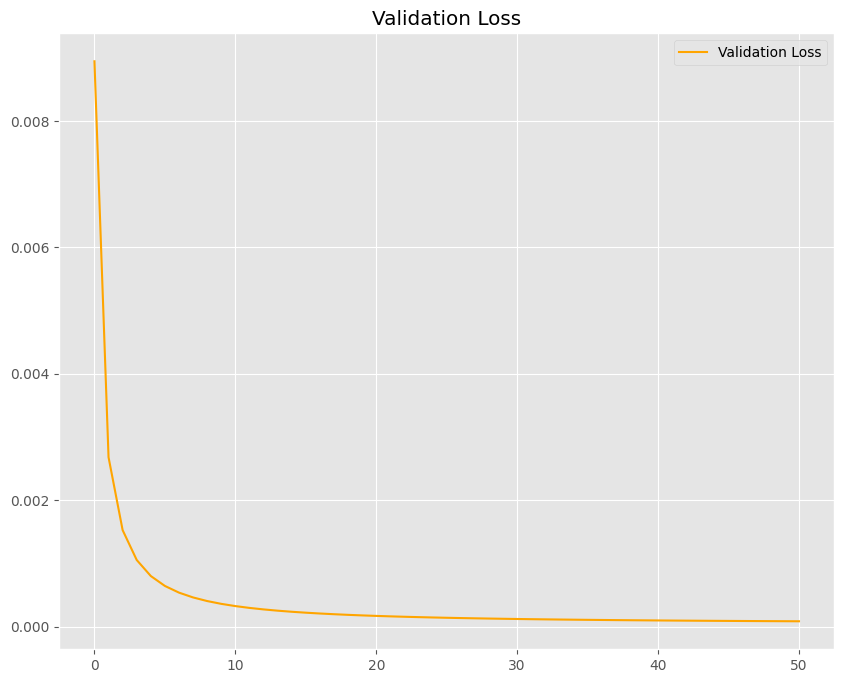

In [161]:
plt.figure(figsize=(10, 8))
plt.plot(validation_loss, label = 'Validation Loss', color = 'orange')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [162]:
df = predict_US_airline_passengers(df, params, raw_data, centroids, devide_lines)
actual_and_predicted = create_actual_and_predicted_df(df)
actual_and_predicted

,Actual,Predicted
2029,17.10,17.150000
2030,17.05,17.286995
2031,17.55,17.402239
2032,17.65,17.517539
2033,17.90,17.632894
2034,17.90,17.748306
2035,18.00,17.863773
2036,18.25,17.979297
2037,18.00,18.116762
2038,18.00,18.232397


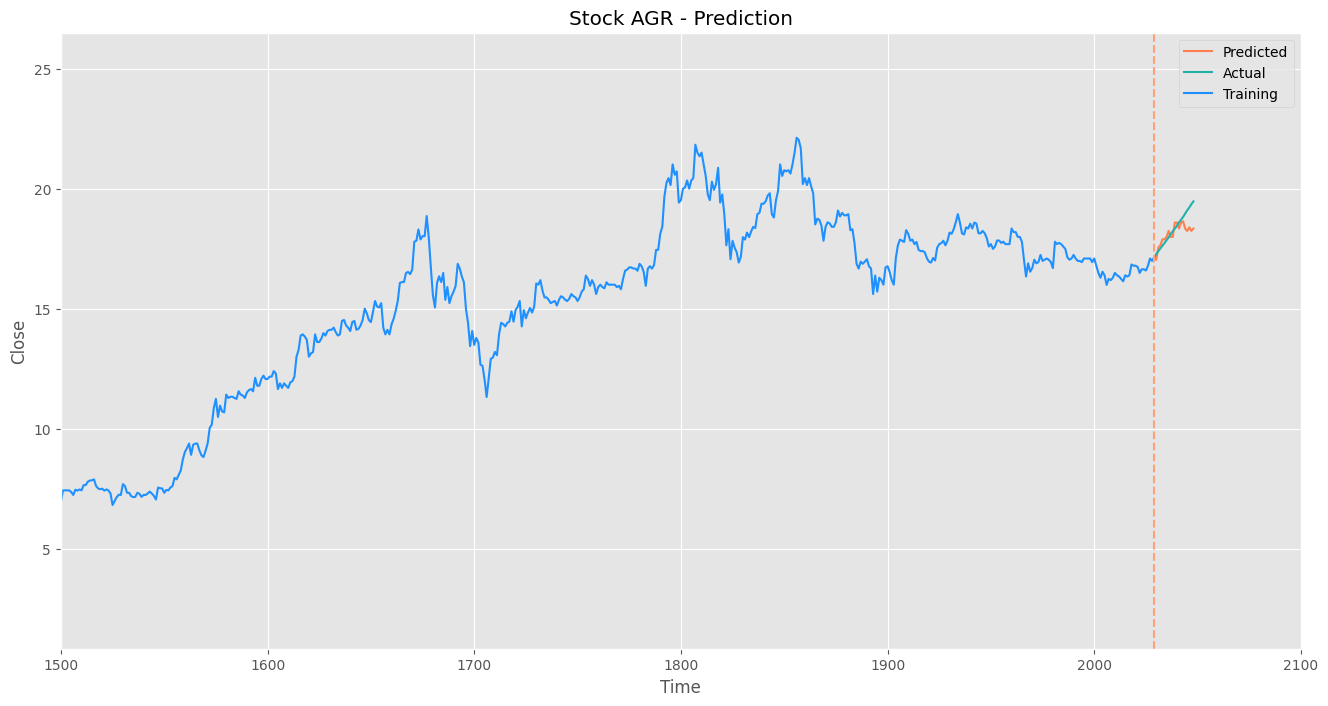

In [163]:
plt.figure(figsize=(16, 8))
plt.plot(actual_and_predicted['Actual'], label='Predicted', color='Coral')
plt.plot(actual_and_predicted['Predicted'], label='Actual', color = 'LightSeaGreen')
plt.plot(df['close'][:int(prediction_start * len(df))], label='Training', color = 'DodgerBlue')
plt.xlabel('Time')
plt.xlim(1500, 2100)
plt.ylabel('Close')
plt.title('Stock AGR - Prediction')
plt.axvline(x = int(prediction_start * len(df)) - 1, linestyle='--', color='LightSalmon')
plt.legend()
plt.show()

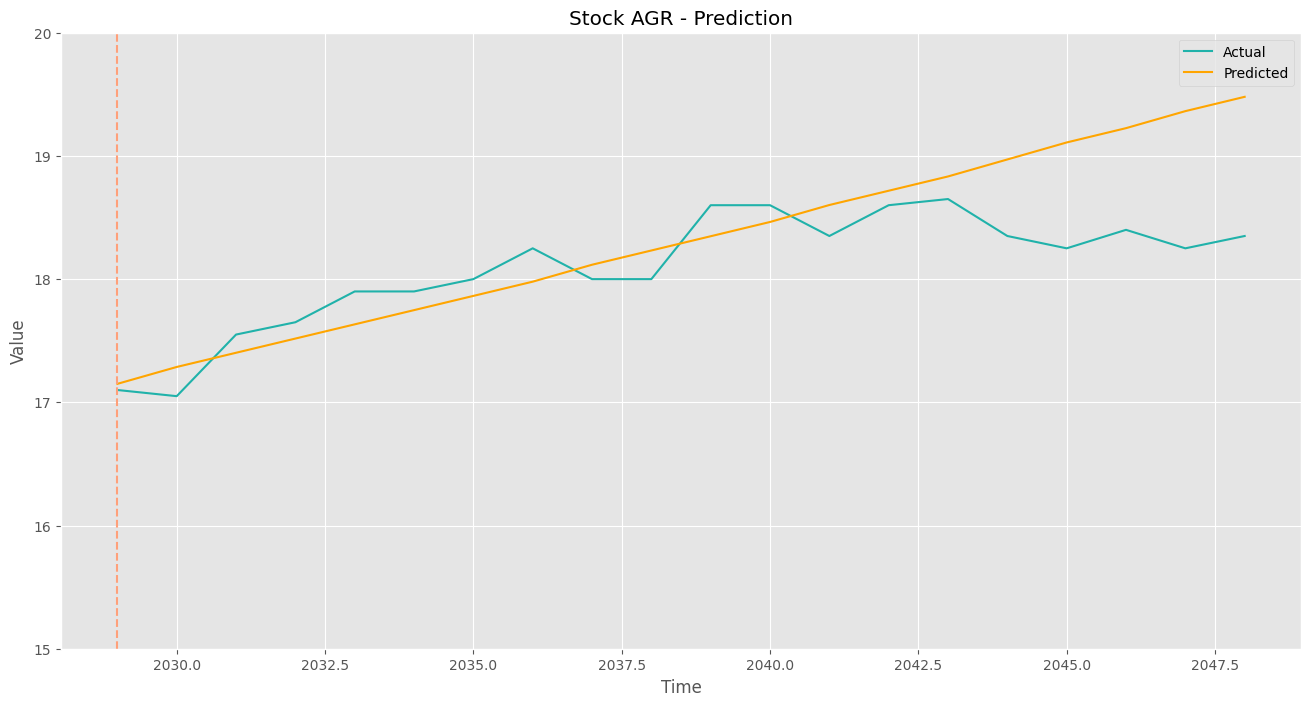

In [164]:
plt.figure(figsize=(16, 8))
plt.plot(actual_and_predicted['Actual'], label='Actual', color='LightSeaGreen')
plt.plot(actual_and_predicted['Predicted'], label='Predicted', color = 'Orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(15, 20)
plt.title('Stock AGR - Prediction')
plt.axvline(x = int(prediction_start * len(df)) - 1, linestyle='--', color='LightSalmon')
plt.legend()
plt.show()

In [165]:
# Determines if the RMSE is considered good based on the rule:
# RMSE should be less than 10% of the range or standard deviation of the target variable.

rmse = calculate_rmse(actual_and_predicted['Predicted'], actual_and_predicted['Actual'])
# is_good = is_rmse_good(rmse, actual_and_predicted['Actual'])

print("RMSE:", rmse)
# print("Is RMSE considered good:", is_good)

RMSE: 0.4932655145296671
